In [1]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import yfinance as yf
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional

# For PLotting we will use these library

import matplotlib.pyplot as plt

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


In [2]:

# Step 1: Data cleaning
data = yf.download(tickers='BTC-usd', start='2014-12-31', end='2022-12-31', interval='1d')
#data = yf.download(tickers='BTC-USD', period='max', interval='1d')
data.dropna(inplace=True)
data


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-12-31,310.914001,320.192993,310.210999,320.192993,320.192993,13942900
2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550
2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400
2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100
...,...,...,...,...,...,...
2022-12-26,16842.250000,16920.123047,16812.369141,16919.804688,16919.804688,11886957804
2022-12-27,16919.291016,16959.845703,16642.072266,16717.173828,16717.173828,15748580239
2022-12-28,16716.400391,16768.169922,16497.556641,16552.572266,16552.572266,17005713920


In [3]:
data= data.to_csv('btc-2015-2022_case2.csv')

In [2]:
data_csv = pd.read_csv('btc-2015-2022_case2.csv')
data_csv.dropna(inplace=True)
# Setting the index

data_csv.set_index('Date', inplace=True)
# Dropping any NaNs
data_csv = data_csv.drop(['Close'], axis=1)
data_csv.dropna(inplace=True)
data_csv.info()
data_csv.tail(10)

<class 'pandas.core.frame.DataFrame'>
Index: 2922 entries, 2014-12-31 to 2022-12-30
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2922 non-null   float64
 1   High       2922 non-null   float64
 2   Low        2922 non-null   float64
 3   Adj Close  2922 non-null   float64
 4   Volume     2922 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 137.0+ KB


,Open,High,Low,Adj Close,Volume
Date,,,,,
2022-12-21,16904.527344,16916.800781,16755.912109,16817.535156,14882945045
2022-12-22,16818.380859,16866.673828,16592.408203,16830.341797,16441573050
2022-12-23,16829.644531,16905.218750,16794.458984,16796.953125,15329265213
2022-12-24,16796.976562,16864.703125,16793.527344,16847.755859,9744636213
2022-12-25,16847.505859,16860.554688,16755.253906,16841.986328,11656379938
2022-12-26,16842.250000,16920.123047,16812.369141,16919.804688,11886957804
2022-12-27,16919.291016,16959.845703,16642.072266,16717.173828,15748580239
2022-12-28,16716.400391,16768.169922,16497.556641,16552.572266,17005713920
2022-12-29,16552.322266,16651.755859,16508.683594,16642.341797,14472237479


In [3]:
# Split the data into training and test sets
train_df = data_csv[:int(len(data_csv)*0.8)]
test_df = data_csv[int(len(data_csv)*0.8):]
data_csv.shape


(2922, 5)

In [4]:
test_data =test_df.copy()

In [5]:
train_x = train_df.index
train_y = train_df['Adj Close']
test_x = test_df.index
test_y = test_df['Adj Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_x, y=train_y, name='train Data'))
fig.add_trace(go.Scatter(x=test_x, y=test_y, name='Test Data'))

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    title='Price over time'
)

fig.show()


In [6]:
print(train_df.info())
print(test_df.info())
print('test_data', test_data.shape)


<class 'pandas.core.frame.DataFrame'>
Index: 2337 entries, 2014-12-31 to 2021-05-24
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2337 non-null   float64
 1   High       2337 non-null   float64
 2   Low        2337 non-null   float64
 3   Adj Close  2337 non-null   float64
 4   Volume     2337 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 109.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 585 entries, 2021-05-25 to 2022-12-30
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       585 non-null    float64
 1   High       585 non-null    float64
 2   Low        585 non-null    float64
 3   Adj Close  585 non-null    float64
 4   Volume     585 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 27.4+ KB
None
test_data (585, 5)


In [7]:
# Preprocess the data
X_train = train_df.drop(['Adj Close'], axis=1).values
y_train = train_df['Adj Close'].values

X_test = test_df.drop(['Adj Close'], axis=1).values
y_test = test_df['Adj Close'].values

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)


x_train (2337, 4)
y_train (2337,)
X_test (585, 4)
y_test (585,)


In [8]:
scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.fit_transform(X_test)
y_train = y_train.reshape(-1,1)
y_train = scaler.fit_transform(y_train)
y_test  = y_test.reshape(-1,1)
y_test  = scaler.fit_transform(y_test)
#------------------------------------------
print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape) 

x_train (2337, 4)
y_train (2337, 1)
X_test (585, 4)
y_test (585, 1)


In [9]:
# Step 5: Reshaping the data
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('Y_test', y_test.shape)
print('X_train.shape[1]', X_train.shape[1])
print('X_train.shape[2]', X_train.shape[2])


X_train (2337, 1, 4)
y_train (2337, 1)
X_test (585, 1, 4)
Y_test (585, 1)
X_train.shape[1] 1
X_train.shape[2] 4


In [10]:
# Step 6: Building the LSTM model (cont.)

model = Sequential()
momodel = Sequential()
model.add(Bidirectional(LSTM(100, input_shape=( X_train.shape[1], X_train.shape[2]),
                             return_sequences=True, activation='tanh')))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100, return_sequences=True, activation='tanh')))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(75, return_sequences=True, activation='tanh')))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(50, activation='tanh')))
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam',
              metrics=[ 'mean_absolute_error'])


In [11]:
# Step 7: Training and evaluating the model
history = model.fit(X_train, y_train, epochs=1000, batch_size=32)


Epoch 1/1000
74/74 [==============================] - 30s 23ms/step - loss: 0.0151 - mean_absolute_error: 0.0638
Epoch 2/1000
74/74 [==============================] - 2s 22ms/step - loss: 8.9340e-04 - mean_absolute_error: 0.0148
Epoch 3/1000
74/74 [==============================] - 2s 22ms/step - loss: 5.8927e-04 - mean_absolute_error: 0.0121
Epoch 4/1000
74/74 [==============================] - 2s 26ms/step - loss: 8.2363e-04 - mean_absolute_error: 0.0153
Epoch 5/1000
74/74 [==============================] - 2s 24ms/step - loss: 5.8094e-04 - mean_absolute_error: 0.0127
Epoch 6/1000
74/74 [==============================] - 2s 24ms/step - loss: 5.3605e-04 - mean_absolute_error: 0.0112
Epoch 7/1000
74/74 [==============================] - 2s 24ms/step - loss: 5.3892e-04 - mean_absolute_error: 0.0114
Epoch 8/1000
74/74 [==============================] - 2s 23ms/step - loss: 5.5118e-04 - mean_absolute_error: 0.0127
Epoch 9/1000
74/74 [==============================] - 2s 25ms/step - loss: 

In [12]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history

    plt.figure(figsize=(16, 5))
    # plt.plot(history['val_mean_absolute_error'])
    plt.plot(history['mean_absolute_error'])
    plt.legend(['val_mean_absolute_error', 'mean_absolute_error'])
    plt.title('mean_absolute_error')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(16, 5))
    # plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()



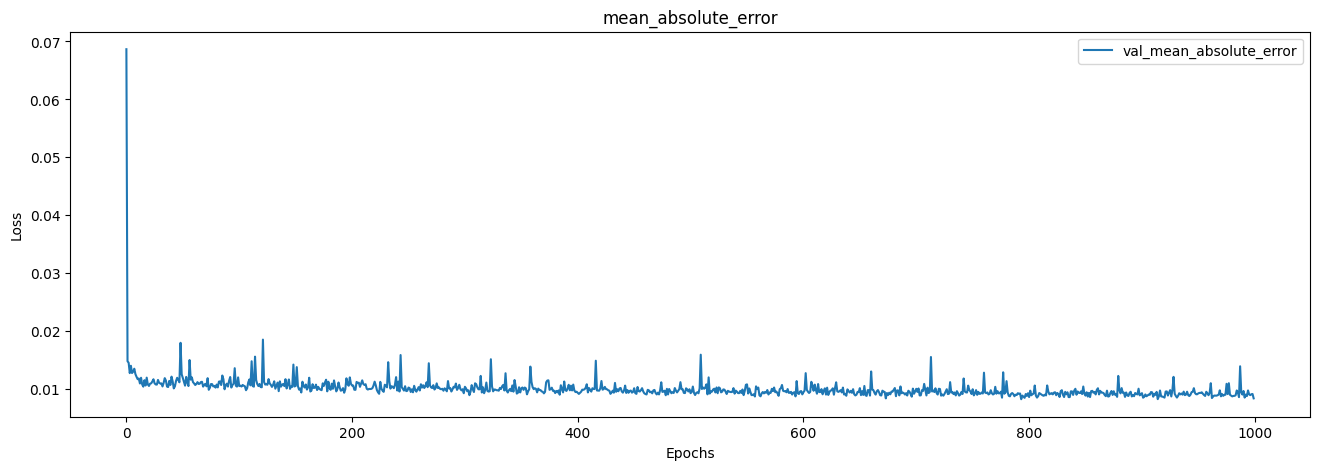

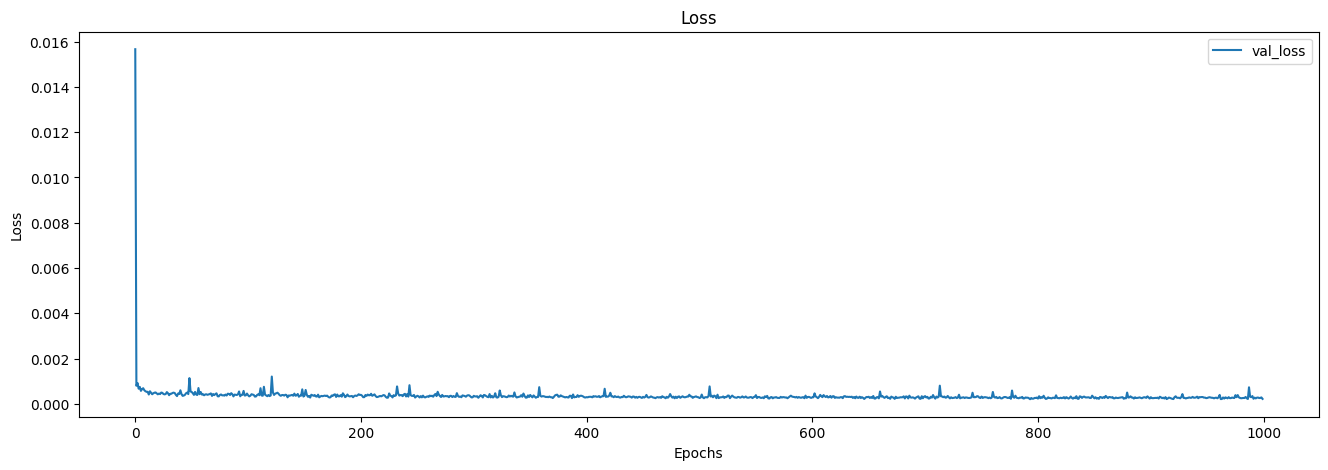

In [15]:
visualize_training_results(history)


In [13]:
# Evaluate the model on the test set
mse, mae = model.evaluate(X_test, y_test)


19/19 [==============================] - 5s 7ms/step - loss: 2.4716e-04 - mean_absolute_error: 0.0110


In [15]:

# Step 8: Testing the model
y_pred = model.predict(X_test)
print('y_pred', y_pred.shape)
print('y_test', y_test.shape)


# evaluat
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("RMSE: {:.4f}".format(rmse))
print("MSE: {:.4f}".format(mse))
print("MAE:{:.4f}".format(mae))


19/19 [==============================] - 5s 7ms/step
y_pred (585, 1)
y_test (585, 1)
RMSE: 0.0157
MSE: 0.0002
MAE:0.0110


In [32]:
# convert to original data
y_pred = scaler.inverse_transform(y_pred)
y_test= scaler.inverse_transform(y_test)


In [19]:

# evaluat

mape = 100 * np.mean(np.abs((y_test - y_pred) / y_test))

print("MAPE: {:.4f}%".format(mape))



MAPE: 1.3734%


In [34]:
y_pred_df = pd.DataFrame(y_pred, columns=["Adj Close"])
y_test_df = pd.DataFrame(y_test, columns=["Adj Close"])

# Get the length of y_pred
y_pred_length = y_pred.shape[0]
y_test_length = y_test.shape[0]

# Generate dates for the next y_pred_length days 
today = pd.Timestamp.now().date()
prediction_dates = today - timedelta(days=y_pred_length-1)
test = today - timedelta(days=y_test_length-1)
prediction = pd.date_range(start=test_data.index[0], end=test_data.index[-1], freq='D')
test_dates = pd.date_range(start=test_data.index[0], end=test_data.index[-1], freq='D')

# Use the generated dates as the index of the DataFrame
y_pred_df['Date'] = prediction

y_test_df['Date'] = test_dates

# Set the index of the dataframes to be the 'Date' column
y_pred_df.set_index('Date', inplace=True)
y_test_df.set_index('Date', inplace=True)


# Assuming y_pred is a numpy array




In [35]:

y_test_df.to_csv("y_test_BTC_case2.csv")
y_test_df

,Adj Close
Date,
2021-05-25,29610.418476
2021-05-26,30771.285468
2021-05-27,29655.638940
2021-05-28,26090.482024
2021-05-29,24682.908047
...,...
2022-12-26,1652.027010
2022-12-27,1388.312148
2022-12-28,1174.090689


In [21]:
y_pred_df.to_csv("y_pred_BTC_case2.csv")  
y_pred_df


,Adj Close
Date,
2021-05-25,38058.421875
2021-05-26,39712.113281
2021-05-27,38623.277344
2021-05-28,36346.980469
2021-05-29,35444.296875
...,...
2022-12-26,16715.396484
2022-12-27,16589.287109
2022-12-28,16432.812500


In [36]:

names = cycle(['Predictions', 'Test Data'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test_df.index, y=y_pred_df['Adj Close'], name='Predictions',
                         line=dict(width=2, color='blue')))
fig.add_trace(go.Scatter(x=y_test_df.index, y=y_test_df['Adj Close'], name='Test Data',
                         line=dict(width=2, color='red')))
fig.update_layout(xaxis_title='Date', yaxis_title='Price',
                  font_size=15, font_color='black', legend_title_text=' Parameters',title= 'Predictions For BTC Case2 (Bi-LSTM)')
fig.show()


In [24]:
# Calculate mean absolute percentage error (MAPE)
def mape(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))


mape_value = mape(y_test, y_pred)
print(f'MAPE: {mape_value:.4f}%')


MAPE: 1.3734%


In [20]:
# Step 1: Data cleaning
#data = yf.download(tickers='BTC-usd', start='2014-12-31', end='2022-12-31', interval='1d')
data_new = yf.download(tickers='BTC-USD', period='max', interval='1d')
data_new.dropna(inplace=True)
data_new.drop(['Close'], axis=1, inplace=True)
data_new


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Adj Close,Volume
Date,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100
...,...,...,...,...,...
2023-04-24,27591.730469,27979.982422,27070.849609,27525.339844,17703288330
2023-04-25,27514.873047,28371.078125,27207.931641,28307.597656,17733373139
2023-04-26,28300.058594,29995.837891,27324.548828,28422.701172,31854242019


In [21]:
future_data = data_new.iloc[-30:, :]
future_data = future_data.values
future_data = pd.DataFrame(future_data, columns=["Open", "High", "Low", "Adj Close", "Volume"])

# Get the length of future_data
future_length = future_data.shape[0]

# Generate dates for the next 30 days
today = pd.Timestamp.now().date()
future_dates = today + timedelta(days=1)

future = pd.date_range(start=future_dates, end=today +
                       timedelta(days=30), freq='D')

# Generate dates for the next 10 days for predict
today = pd.Timestamp.now().date()
future_dates_pred = pd.date_range(start=today, periods=10, freq='D')

# Use the generated dates as the index of the DataFrame
future_data['Date'] = future

# Set the index of the dataframes to be the 'Date' column
future_data.set_index('Date', inplace=True)

future_data.tail(10)
x_future_data = future_data.drop(['Adj Close'], axis=1).values
y_future_data = future_data['Adj Close'].values
y_future_data = y_future_data.reshape(-1, 1)

print("x_future_data:", x_future_data.shape)
print("y_future_data:", y_future_data.shape)

# x_future_data= np.reshape(x_future_data, (x_future_data.shape[0], 1, x_future_data.shape[1]))

print("x_future_data:", x_future_data.shape)
x_future_data = scaler.fit_transform(x_future_data)
y_future_data = scaler.fit_transform(y_future_data)
for i in range(10):
    future_data_temp = x_future_data[i:i+30, :]
    # future_data_temp = future_data_temp.reshape(-1, 1)
    print("future_data_temp", future_data_temp.shape)


x_future_data: (30, 4)
y_future_data: (30, 1)
x_future_data: (30, 4)
future_data_temp (30, 4)
future_data_temp (29, 4)
future_data_temp (28, 4)
future_data_temp (27, 4)
future_data_temp (26, 4)
future_data_temp (25, 4)
future_data_temp (24, 4)
future_data_temp (23, 4)
future_data_temp (22, 4)
future_data_temp (21, 4)


In [22]:
# Initialize a numpy array to store the predictions
prediction = np.zeros((10, 1))

for i in range(10):
    future_data_temp = x_future_data[i:i+30, :]

    print("future_data_temp1", future_data_temp.shape)
    future_data_temp = np.reshape(future_data_temp, (future_data_temp.shape[0],
                                                     1, future_data_temp.shape[1]))
    pred = model.predict(future_data_temp)
    print("future_data_temp2", future_data_temp.shape)
    print('---------------------------------------------------')
    prediction[i][0] = pred[0][0]
    x_future_data[i+future_data_temp.shape[0]-1][0] = pred[0][0]
print('3', future_data.shape)
print('prediction:', prediction.shape)
# Reverse the MinMaxScaler
y_future_data = y_future_data.reshape(-1, 1)
y_future_data = scaler.inverse_transform(y_future_data)
prediction = scaler.inverse_transform(prediction)

# Create a new dataframe with the predicted values and the dates as the index
prediction_df = pd.DataFrame(
    prediction, index=future_dates_pred, columns=['Adj Close'])
print('y_future_data', y_future_data.shape)
# Get the length of future_data

y_future_data = pd.DataFrame(y_future_data,  columns=['Adj Close'])

future_length = future_data.shape[0]
test = today - timedelta(days=future_length-1)
test_dates = pd.date_range(start=test, end=today, freq='D')
# Use the generated dates as the index of the DataFrame


y_future_data['Date'] = test_dates

# Set the index of the dataframes to be the 'Date' column

y_future_data.set_index('Date', inplace=True)


future_data_temp1 (30, 4)
1/1 [==============================] - 0s 172ms/step
future_data_temp2 (30, 1, 4)
---------------------------------------------------
future_data_temp1 (29, 4)
1/1 [==============================] - 0s 70ms/step
future_data_temp2 (29, 1, 4)
---------------------------------------------------
future_data_temp1 (28, 4)
1/1 [==============================] - 0s 57ms/step
future_data_temp2 (28, 1, 4)
---------------------------------------------------
future_data_temp1 (27, 4)
1/1 [==============================] - 0s 67ms/step
future_data_temp2 (27, 1, 4)
---------------------------------------------------
future_data_temp1 (26, 4)
1/1 [==============================] - 0s 72ms/step
future_data_temp2 (26, 1, 4)
---------------------------------------------------
future_data_temp1 (25, 4)
1/1 [==============================] - 0s 38ms/step
future_data_temp2 (25, 1, 4)
---------------------------------------------------
future_data_temp1 (24, 4)
1/1 [==============

In [23]:
prediction_df


,Adj Close
2023-04-28,28389.994666
2023-04-29,27992.929871
2023-04-30,28359.602219
2023-05-01,27864.736937
2023-05-02,27571.205849
2023-05-03,27970.619301
2023-05-04,28169.939923
2023-05-05,27610.649376
2023-05-06,27656.380773
2023-05-07,27811.053336


In [24]:
y_future_data


,Adj Close
Date,
2023-03-30,28033.562500
2023-03-31,28478.484375
2023-04-01,28411.035156
2023-04-02,28199.308594
2023-04-03,27790.220703
2023-04-04,28168.089844
2023-04-05,28177.984375
2023-04-06,28044.140625
2023-04-07,27925.859375


In [25]:
names = cycle(['Predictions next 10 day', 'Actual data '])

fig = go.Figure()

fig.add_trace(go.Scatter(x=y_future_data.index, y=y_future_data['Adj Close'], name='Actual data ',
                         line=dict(width=2, color='red')))
fig.add_trace(go.Scatter(x=prediction_df.index, y=prediction_df['Adj Close'], name='Predictions next 10 day',
                         line=dict(width=2, color='blue')))

fig.add_shape(type='line',
              x0=prediction_df.index[0], y0=prediction_df['Adj Close'][0],
              x1=y_future_data.index[-1], y1=y_future_data['Adj Close'][-1],
              line=dict(color='grey', width=2))
fig.update_layout(xaxis_title='Date', yaxis_title='Price',
                  font_size=15, font_color='black', legend_title_text=' Parameters')
fig.show()


In [26]:
actual_x = y_future_data.index
actual_y = y_future_data['Adj Close']
pred_x = prediction_df.index
pred_y = prediction_df['Adj Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=actual_x, y=actual_y, name='Actual Data'))
fig.add_trace(go.Scatter(x=pred_x, y=pred_y,
              name='Predictions Data for 10 day'))

fig.add_shape(type='line',
              x0=actual_x[-1], y0=actual_y[-1],
              x1=pred_x[0], y1=pred_y[0],
              line=dict(color='grey', width=2))

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    title='predict next 10 day '
)

fig.show()


In [27]:
future_data_all = data_new.copy()

future_data_all = pd.DataFrame(future_data_all, index= future_data_all.index, 
                               columns=future_data_all.columns)

x_future_data_all = future_data_all.drop(['Adj Close'], axis=1).values
y_future_data_all = future_data_all['Adj Close'].values
y_future_data_all = y_future_data_all.reshape(-1, 1)

print("x_future_data:", x_future_data_all.shape)
print("y_future_data:", y_future_data_all.shape)


x_future_data: (3146, 4)
y_future_data: (3146, 1)


In [28]:
x_future_data_all = scaler.fit_transform(x_future_data_all)
y_future_data_all = scaler.fit_transform(y_future_data_all)

x_future_data_all = np.reshape(x_future_data_all, (x_future_data_all.shape[0], 1, x_future_data_all.shape[1]))

pred_future_all = model.predict(x_future_data_all)


99/99 [==============================] - 1s 8ms/step


In [29]:

y_future_data_all = scaler.inverse_transform(y_future_data_all)
pred_future_all = scaler.inverse_transform(pred_future_all)
y_future_all = pd.DataFrame(y_future_data_all, index= future_data_all.index,  columns=['Adj Close'])
pred_future_all_df = pd.DataFrame(pred_future_all, index= future_data_all.index,  columns=['Adj Close'])
print("pred_future_all:", pred_future_all.shape)
print("y_future_data:", y_future_data_all.shape)

pred_future_all: (3146, 1)
y_future_data: (3146, 1)


In [30]:
names = cycle(['Predictions', 'Test Data'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_future_all.index, y=pred_future_all_df['Adj Close'], name='Predictions',
                         line=dict(width=2, color='blue')))
fig.add_trace(go.Scatter(x=y_future_all.index, y=y_future_all['Adj Close'], name='Actual Data',
                         line=dict(width=2, color='red')))
fig.add_trace(go.Scatter(x=prediction_df.index, y=prediction_df['Adj Close'], name='Predictions next 10 day',
                         line=dict(width=2, color='gray')))
fig.add_shape(type='line',
              x0=prediction_df.index[0], y0=prediction_df['Adj Close'][0],
              x1=pred_future_all_df.index[-1], y1=pred_future_all_df['Adj Close'][-1],
              line=dict(color='grey', width=2))

fig.update_layout(xaxis_title='Date', yaxis_title='Price',
                  font_size=15, font_color='black', legend_title_text=' Parameters', title = 'Bi-LSTM predictions For BTC case2 10 Days')
fig.show()
